In [2]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import SpikeTrain, TuningCurve, NeuralTrajectory
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

code_id = "0838 - Neural Trajectory Remapping"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

def get_neural_traj(trace: dict, lap_perfect: int = 1):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    
    neural_trajs = []
    pos_trajs = []
    route_trajs = []
    lap_trajs = []
    map_trajs = []
    speed_trajs = []
    
    for i in tqdm(range(beg_idx.shape[0])):
        if trace['is_perfect'][i] != lap_perfect:
            continue
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        neural_traj = spike_train.calc_neural_trajectory(500, 100)
        neural_traj_vec = neural_traj.to_array()
        pos_traj = neural_traj.variable.to_array()
        time_traj = neural_traj.time
        
        neural_trajs.append(neural_traj_vec)
        pos_trajs.append(pos_traj)
        dx, dy = np.ediff1d(trace['correct_pos'][:, 0]), np.ediff1d(trace['correct_pos'][:, 1])
        dt = np.ediff1d(trace['correct_time'])
        speed = np.sqrt(dx**2+dy**2) / dt * 100
        speed = np.convolve(speed, np.ones(3)/3, mode='same')
        idx = _coordinate_recording_time(time_traj.astype(np.float64), trace['correct_time'].astype(np.float64))
        speed_trajs.append(speed[idx])
        route_trajs.append(np.repeat(routes[i], neural_traj_vec.shape[1]).astype(np.int64))
        lap_trajs.append(np.repeat(i, neural_traj_vec.shape[1]).astype(np.int64))
        map_trajs.append(np.repeat(trace['map_cluster'][i], neural_traj_vec.shape[1]))
    
    return np.concatenate(neural_trajs, axis=1), np.concatenate(pos_trajs), np.concatenate(route_trajs), np.concatenate(lap_trajs), np.concatenate(map_trajs), np.concatenate(speed_trajs)


        E:\Data\FinalResults\Dsp\0838 - Neural Trajectory Remapping is already existed!


In [3]:
def hex_to_rgba(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-255).
    """
    hex_color = hex_color.lstrip('#')  # Remove '#' if present
    if len(hex_color) == 6:
        r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
        a = 255  # Default alpha
    elif len(hex_color) == 8:
        r, g, b, a = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16), int(hex_color[6:8], 16)
    else:
        raise ValueError("Invalid hex color format. Use #RRGGBB or #RRGGBBAA.")
    return r, g, b, a

def hex_to_rgba_normalized(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-1).
    """
    r, g, b, a = hex_to_rgba(hex_color)
    return np.array([r / 255, g / 255, b / 255, a / 255])

DSPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in DSPPalette])
MAPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in ['#333766', '#A4C096']])

In [ ]:
from umap.umap_ import UMAP
from matplotlib import cm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

def plot(traces, index_map, elev = 50, azim = 160):
    count_map = np.where(index_map > 0, 1, 0)
    sums = np.sum(count_map, axis=0)
    idx = np.where(sums == 7)[0]
    
    neural_trajs, pos_trajs, route_trajs, lap_trajs, map_trajs = [], [], [], [], []
    session_trajs = []
    for i in range(len(traces)):
        neural_traj, pos_traj, route_traj, lap_traj, map_traj, speed_traj = get_neural_traj(traces[i])
        neural_trajs.append(neural_traj[index_map[i, idx]-1, :])
        pos_trajs.append(pos_traj)
        route_trajs.append(route_traj)
        lap_trajs.append(lap_traj)
        session_trajs.append(np.repeat(i, len(lap_traj)))
        map_trajs.append(map_traj)
        
    neural_traj = np.concatenate(neural_trajs, axis=1)
    pos_traj = np.concatenate(pos_trajs)
    route_traj = np.concatenate(route_trajs)
    lap_traj = np.concatenate(lap_trajs)
    session_traj = np.concatenate(session_trajs)
    map_traj = np.concatenate(map_trajs)
    map_traj[map_traj==2] = 1

    overlapping_bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])-1

    print(route_traj)
    idx = np.where((np.isin(pos_traj, overlapping_bins)) & (np.isin(route_traj, [0, 1.,2., 3., 4., 5.,6.])))[0]

    neural_traj = neural_traj[:, idx]
    pos_traj = pos_traj[idx]

    oldbin_traj = spike_nodes_transform(pos_traj+1, 12)
    route_traj = route_traj[idx]
    lap_traj = lap_traj[idx]
    session_traj = session_traj[idx]
    map_traj = map_traj[idx]

    D = GetDMatrices(1, 48)
    dist_traj = D[pos_traj, 2303]
    dists = (dist_traj // 2).astype(np.int64)
    lda_label = dists + np.max(dists + 1) * route_traj

    print(neural_traj.shape, pos_traj.shape, route_traj.shape, lap_traj.shape)

    pca = PCA(n_components=30)
    denoised_data = pca.fit_transform(neural_traj.T)
    model = UMAP(n_components=3)
    reduced_data = model.fit_transform(denoised_data)
    PC1, PC2, PC3 = reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2]

    svm = SVC()
    svm.fit(reduced_data[:, :3], map_traj)

    map_clusters = svm.predict(reduced_data[:, :3])
    manifold_colors = MAPPaletteRGBA[map_clusters, :]

    dist_colors = plt.get_cmap("rainbow")(dist_traj/np.max(dist_traj))
    session_colors = plt.get_cmap("rainbow")(session_traj/np.max(session_traj))
    route_colors = DSPPaletteRGBA[route_traj.astype(np.int64), :]

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), subplot_kw={'projection': '3d'})
    
    dlap = np.ediff1d(lap_traj)
    beg = np.concatenate([[0], np.where(dlap != 0)[0]+1])
    end = np.concatenate([np.where(dlap != 0)[0]+1, [lap_traj.shape[0]]])
    
    # Each route select 10 laps
    selected_beg, selected_end = [], []
    for route in range(7):
        for day in range(7):
            idx = np.where((route_traj[beg] == route)&(session_traj[beg] == day))[0]
            selected_idx = np.random.choice(idx, 5, replace = False)
            selected_beg.append(beg[selected_idx])
            selected_end.append(end[selected_idx])
        
    selected_beg, selected_end = np.concatenate(selected_beg), np.concatenate(selected_end)
    
    print(f"{beg.shape[0]} Laps total")
    session_colors2 = sns.color_palette("rainbow", 7)
    exclude_idx = []
    for i in range(selected_beg.shape[0]):
        beg_idx, end_idx = selected_beg[i], selected_end[i]
        if np.unique(map_clusters[beg_idx:end_idx]).shape[0] == 2:
            exclude_idx.append(i)
            continue
        
        axes[0].plot(PC1[beg_idx:end_idx], PC2[beg_idx:end_idx], PC3[beg_idx:end_idx], linewidth=1, color = DSPPalette[route_traj[beg_idx]])
        axes[2].plot(PC1[beg_idx:end_idx], PC2[beg_idx:end_idx], PC3[beg_idx:end_idx], linewidth=1, color = ['#333766', '#A4C096'][map_clusters[beg_idx]])
        axes[1].scatter( 
            PC1[beg_idx:end_idx], 
            PC2[beg_idx:end_idx], 
            PC3[beg_idx:end_idx],
            color=dist_colors[beg_idx:end_idx, :],
            s=5,
            alpha=0.8,
            linewidth = 0
        )
        
    axes[0].set_xlabel("UMAP1")
    axes[0].set_ylabel("UMAP2")
    exclude_idx = np.array(exclude_idx)
    axes[0].view_init(elev=elev, azim=azim)
    axes[1].view_init(elev=elev, azim=azim)
    axes[2].view_init(elev=elev, azim=azim)
    plt.savefig(join(loc, f"{traces[0]['MiceID']} [example].png"), dpi=600)
    plt.savefig(join(loc, f"{traces[0]['MiceID']} [example].svg"), dpi=600)
    plt.show()
    
    fig = plt.figure(figsize=(4, 4))
    ax = Clear_Axes(plt.axes())
    DrawMazeProfile(axes=ax, color='k', linewidth = 0.5)
    x, y = (pos_traj) % 48 + np.random.rand(pos_traj.shape[0])-0.5, pos_traj // 48 + np.random.rand(pos_traj.shape[0])-0.5
    idx = np.concatenate([np.arange(selected_beg[i], selected_end[i]) for i in np.setdiff1d(np.arange(selected_beg.shape[0]), exclude_idx)])
    ax.scatter(
        x[idx], y[idx], color = dist_colors[idx], 
        s=2, alpha=0.8, linewidth = 0
    )
    plt.savefig(join(loc, f"{traces[0]['MiceID']} [example] position.png"), dpi=600)
    plt.savefig(join(loc, f"{traces[0]['MiceID']} [example] position.svg"), dpi=600)
    plt.show()

traces = []
mouse = 10227
for i in np.where(f2['MiceID'] == mouse)[0]:
    with open(f2['Trace File'][i], 'rb') as handle:
        trace = pickle.load(handle)
    traces.append(trace)

with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as handle:
    index_map = pickle.load(handle)
    
    if mouse != 10232:
        index_map = index_map[1:, :]
    
    index_map = index_map.astype(np.int64)
plot(traces, index_map.astype(np.int64))

100%|██████████| 130/130 [00:00<00:00, 248.13it/s]


[0 0 0 ... 0 0 0]
(261, 26915) (26915,) (26915,) (26915,)


# Cross Manifold Analysis

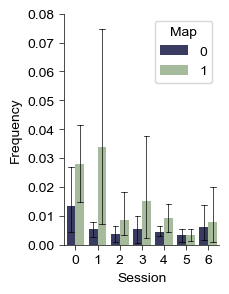

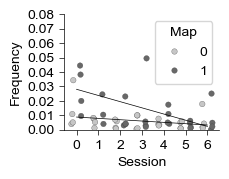

Session 1  Ttest_indResult(statistic=-1.3476641386651667, pvalue=0.22642415090685056)
Session 2  Ttest_indResult(statistic=-1.324539642695143, pvalue=0.2335378999654511)
Session 3  Ttest_indResult(statistic=-0.9438417589600673, pvalue=0.38168739022972054)
Session 4  Ttest_indResult(statistic=-0.8156387034569224, pvalue=0.4458698727418329)
Session 5  Ttest_indResult(statistic=-1.5012211918291418, pvalue=0.1839743193255362)
Session 6  Ttest_indResult(statistic=-0.10246253994308009, pvalue=0.9217281880097282)
Session 7  Ttest_indResult(statistic=-0.2516763036282979, pvalue=0.8096898361883305)

Map 0: LinregressResult(slope=-0.0009217078617298855, intercept=0.008780947579247949, rvalue=-0.2753728262882408, pvalue=0.15610461394948008, stderr=0.000631046589135336, intercept_stderr=0.0022752708343341107)
Map 1: LinregressResult(slope=-0.004285433314316047, intercept=0.028007591029027463, rvalue=-0.418925523492971, pvalue=0.02649542360393316, stderr=0.0018216584247069483, intercept_stderr=0.00

In [24]:
from umap.umap_ import UMAP
from matplotlib import cm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

def counts(traces, index_map):
    count_map = np.where(index_map > 0, 1, 0)
    sums = np.sum(count_map, axis=0)
    idx = np.where(sums == 7)[0]
    
    neural_trajs, pos_trajs, route_trajs, lap_trajs, map_trajs, speed_trajs = [], [], [], [], [], []
    session_trajs = []
    for i in range(len(traces)):
        neural_traj, pos_traj, route_traj, lap_traj, map_traj, speed_traj = get_neural_traj(traces[i])
        neural_trajs.append(neural_traj[index_map[i, idx]-1, :])
        pos_trajs.append(pos_traj)
        route_trajs.append(route_traj)
        lap_trajs.append(lap_traj)
        session_trajs.append(np.repeat(i, len(lap_traj)))
        map_trajs.append(map_traj)
        speed_trajs.append(speed_traj)
        
    neural_traj = np.concatenate(neural_trajs, axis=1)
    pos_traj = np.concatenate(pos_trajs)
    route_traj = np.concatenate(route_trajs)
    lap_traj = np.concatenate(lap_trajs)
    session_traj = np.concatenate(session_trajs)
    map_traj = np.concatenate(map_trajs)
    speed_traj = np.concatenate(speed_trajs)
    map_traj[map_traj==2] = 1

    overlapping_bins = np.concatenate([Father2SonGraph[i] for i in CP_DSP[3]])-1

    print(route_traj)
    idx = np.where((np.isin(pos_traj, overlapping_bins)) & (np.isin(route_traj, [0, 1.,2., 3., 4., 5.,6.])))[0]

    neural_traj = neural_traj[:, idx]
    pos_traj = pos_traj[idx]
    route_traj = route_traj[idx]
    lap_traj = lap_traj[idx]
    session_traj = session_traj[idx]
    map_traj = map_traj[idx]
    speed_traj = speed_traj[idx]

    print(neural_traj.shape, pos_traj.shape, route_traj.shape, lap_traj.shape)

    D = GetDMatrices(1, 48)
    dist_traj = D[pos_traj, 2303]
    dists = (dist_traj // 2).astype(np.int64)

    pca = PCA(n_components=30)
    denoised_data = pca.fit_transform(neural_traj.T)
    model = UMAP(n_components=3)
    reduced_data = model.fit_transform(denoised_data)

    svm = SVC()
    svm.fit(reduced_data[:, :3], map_traj)

    map_clusters = svm.predict(reduced_data[:, :3])
    dist_clusters = svm.decision_function(reduced_data[:, :3])
     
    dlap = np.ediff1d(lap_traj)
    beg = np.concatenate([[0], np.where(dlap != 0)[0]+1])
    end = np.concatenate([np.where(dlap != 0)[0]+1, [lap_traj.shape[0]]])
    
    return map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end

"""
def identify_transition(dist_piece: np.ndarray, low_b: float, hig_b: float):
    map_piece = np.where(dist_piece >= 0, 1, 0)
    for i in range(1, len(map_piece)):
        if map_piece[i-1] == 0 and map_piece[i] == 1:
            if dist_piece[i] < hig_b:
                map_piece[i] = 0
        elif map_piece[i-1] == 1 and map_piece[i] == 0:
            if dist_piece[i] > low_b:
                map_piece[i] = 1
    dmap = np.ediff1d(map_piece)

    if map_piece[0] == 0:
        return 0, np.where(dmap==1)[0].shape[0]
    else:
        return 1, np.where(dmap==-1)[0].shape[0]

def transitions(
    dist_clusters: np.ndarray,
    session_clusters: np.ndarray,
    beg: np.ndarray, end:np.ndarray
):
    nlap0, nlap1 = np.zeros(7), np.zeros(7)
    nswitch0, nswitch1 = np.zeros(7), np.zeros(7)
    low_b, hig_b = np.min(dist_clusters)*0.1, np.max(dist_clusters)*0.1
    for i in range(len(beg)):
        maptype, count = identify_transition(
            dist_clusters[beg[i]:end[i]], low_b, hig_b
        )
        if maptype == 0:
            nlap0[session_clusters[beg[i]]] += 1
            nswitch0[session_clusters[beg[i]]] += count
        else:
            nlap1[session_clusters[beg[i]]] += 1
            nswitch1[session_clusters[beg[i]]] += count
            
    return nswitch0/nlap0, nswitch1/nlap1
"""

def identify_transition(dist_piece: np.ndarray, low_b: float, hig_b: float):
    map_piece = np.where(dist_piece >= 0, 1, 0)
    for i in range(1, len(map_piece)):
        if map_piece[i-1] == 0 and map_piece[i] == 1:
            if dist_piece[i] < hig_b:
                map_piece[i] = 0
        elif map_piece[i-1] == 1 and map_piece[i] == 0:
            if dist_piece[i] > low_b:
                map_piece[i] = 1
    dmap = np.ediff1d(map_piece)
    idx = np.where(dmap != 0)[0]
    
    # State transition should maintain for over 500 ms (5 time bins)
    if len(idx) == 0:
        return idx, np.where(dmap[idx] == -1, 1, 0), map_piece

    delete_idx = []
    jump_idx = -1
    for i in range(0, len(idx)-1):
        if i == jump_idx:
            continue
        
        try:
            if idx[i+1] - idx[i] <= 5:
                delete_idx.append(i)
                delete_idx.append(i+1)
                jump_idx = i+1
        except:
            pass
    
    if len(delete_idx) > 0:
        idx = np.delete(idx, np.array(delete_idx))

    #idx = idx[dmap[idx] == dmap[idx[0]]]
    return idx, np.where(dmap[idx] == -1, 1, 0), map_piece

def transitions(
    dist_clusters: np.ndarray,
    session_clusters: np.ndarray,
    beg: np.ndarray, end:np.ndarray
):
    
    nlap0, nlap1 = np.zeros(7), np.zeros(7)
    nswitch0, nswitch1 = np.zeros(7), np.zeros(7)
    low_b, hig_b = 0, 0
    for i in range(len(beg)):
        dmap, map_type, map_piece = identify_transition(
            dist_clusters[beg[i]:end[i]], low_b, hig_b
        )
        n_session = session_clusters[beg[i]]
        
        if dist_clusters[beg[i]] < 0:
            nlap0[n_session] += np.where(map_piece == 0)[0].shape[0]
        else:
            nlap1[n_session] += np.where(map_piece == 1)[0].shape[0]        
        
        if map_type.shape[0] == 0:
            continue
            
        nswitch0[n_session] += np.where(map_type == 0)[0].shape[0]
        nswitch1[n_session] += np.where(map_type == 1)[0].shape[0]
            
    return nswitch0/nlap0, nswitch1/nlap1

if exists(join(figdata, code_id+" [switch frequency].pkl")) == False:
    Data = {
        "MiceID": [],
        "Session": [],
        "Frequency": [],
        "Map": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        if exists(join(loc, f"{mouse}.pkl")):
            with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
                map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end = pickle.load(handle)
        else:
            traces = []
            for i in np.where(f2['MiceID'] == mouse)[0]:
                with open(f2['Trace File'][i], 'rb') as handle:
                    trace = pickle.load(handle)
                traces.append(trace)

            with open(f_CellReg_dsp['cellreg_folder'][1+m], 'rb') as handle:
                index_map = pickle.load(handle)
            
                if mouse != 10232:
                    index_map = index_map[1:, :]
            
            map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end = counts(traces, index_map.astype(np.int64))
            with open(join(loc, f"{mouse}.pkl"), 'wb') as f:
                pickle.dump(
                    [map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end],
                    f
                )
                
        freq0, freq1 = transitions(dist_clusters, session_traj, beg, end)
        
        Data['MiceID'].append(np.repeat(mouse, 14))
        Data['Frequency'] += [freq0, freq1]
        Data['Session'] += [np.arange(7), np.arange(7)]
        Data['Map'] += [np.repeat(0, 7), np.repeat(1, 7)]
        
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
        
    with open(join(figdata, code_id+' [switch frequency].pkl'), 'wb') as handle:
        pickle.dump(Data, handle)
    
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, code_id+' [switch frequency].xlsx'), index=False)
else:
    with open(join(figdata, code_id+' [switch frequency].pkl'), 'rb') as handle:
        Data = pickle.load(handle)
    
        
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
k0, b0, _, _, _ = linregress(
    Data['Session'][Data['Map'] == 0], 
    Data['Frequency'][Data['Map'] == 0]
)
k1, b1, _, _, _ = linregress(
    Data['Session'][Data['Map'] == 1], 
    Data['Frequency'][Data['Map'] == 1]
)
x = np.linspace(0, 6, 7)
y0 = k0*x+b0
y1 = k1*x+b1
sns.barplot(
    x='Session',
    y='Frequency',
    data=Data,
    hue='Map',
    palette=['#333766', '#A4C096'],
    capsize=0.5,
    linewidth=0.5,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(0, 0.08)
ax.set_yticks(np.linspace(0, 0.08, 9))
plt.savefig(join(loc, "Map Transition Probability [bar].png"), dpi=600)
plt.savefig(join(loc, "Map Transition Probability [bar].svg"), dpi=600)
plt.show()
fig = plt.figure(figsize=(2, 1.5))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Session',
    y='Frequency',
    data=Data,
    hue='Map',
    dodge=True,
    palette="Grays",
    size = 4,
    linewidth=0.2,
    zorder=2
)
ax.plot(x, y0, color='k', linewidth=0.5)
ax.plot(x, y1, color='k', linewidth=0.5)
ax.set_ylim(0, 0.08)
ax.set_yticks(np.linspace(0, 0.08, 9))
ax.axhline(0, ls=':', linewidth=0.5, c='k')
plt.savefig(join(loc, "Map Transition Probability.png"), dpi=600)
plt.savefig(join(loc, "Map Transition Probability.svg"), dpi=600)
plt.show()

for i in range(7):
    idx0 = np.where((Data['Session'] == i)&(Data['Map'] == 0))[0]
    idx1 = np.where((Data['Session'] == i)&(Data['Map'] == 1))[0]
    print(f"Session {i+1}  {ttest_ind(Data['Frequency'][idx0], Data['Frequency'][idx1])}")
    
print()
print(f"Map 0: {linregress(Data['Session'][Data['Map'] == 0], Data['Frequency'][Data['Map'] == 0])}")
print(f"Map 1: {linregress(Data['Session'][Data['Map'] == 1], Data['Frequency'][Data['Map'] == 1])}")

# Distribution of Transition position

C:\Users\12454\AppData\Local\Temp\ipykernel_13920\3662225139.py:182: RuntimeWarning: divide by zero encountered in divide
  ratemap0 = pos0_count / occu_bin2[0, :, day]
C:\Users\12454\AppData\Local\Temp\ipykernel_13920\3662225139.py:182: RuntimeWarning: invalid value encountered in divide
  ratemap0 = pos0_count / occu_bin2[0, :, day]
C:\Users\12454\AppData\Local\Temp\ipykernel_13920\3662225139.py:183: RuntimeWarning: divide by zero encountered in divide
  ratemap1 = pos1_count / occu_bin2[1, :, day]
C:\Users\12454\AppData\Local\Temp\ipykernel_13920\3662225139.py:183: RuntimeWarning: invalid value encountered in divide
  ratemap1 = pos1_count / occu_bin2[1, :, day]
C:\Users\12454\AppData\Local\Temp\ipykernel_13920\3662225139.py:182: RuntimeWarning: divide by zero encountered in divide
  ratemap0 = pos0_count / occu_bin2[0, :, day]
C:\Users\12454\AppData\Local\Temp\ipykernel_13920\3662225139.py:182: RuntimeWarning: invalid value encountered in divide
  ratemap0 = pos0_count / occu_bin2[

PearsonRResult(statistic=0.14269648804776913, pvalue=0.07461415992970935)
PearsonRResult(statistic=-0.1957611622178029, pvalue=0.004406137116841919)
PearsonRResult(statistic=-0.14460734499532385, pvalue=0.04315622702021314)
PearsonRResult(statistic=0.6303114872568927, pvalue=2.5285847617276933e-23)


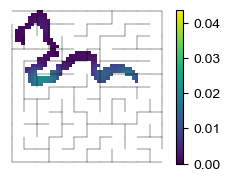

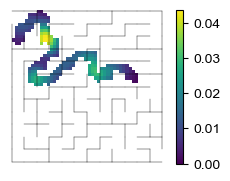

In [7]:
import scipy.stats


def identify_transition_pos(dist_piece: np.ndarray, low_b: float, hig_b: float):
    map_piece = np.where(dist_piece >= 0, 1, 0)
    for i in range(1, len(map_piece)):
        if map_piece[i-1] == 0 and map_piece[i] == 1:
            if dist_piece[i] < hig_b:
                map_piece[i] = 0
        elif map_piece[i-1] == 1 and map_piece[i] == 0:
            if dist_piece[i] > low_b:
                map_piece[i] = 1
    dmap = np.ediff1d(map_piece)

    if map_piece[0] == 0:
        return 0, np.where(dmap==1)[0]
    else:
        return 1, np.where(dmap==-1)[0]

def transitions_pos(
    dist_clusters: np.ndarray,
    session_clusters: np.ndarray,
    pos_clusters: np.ndarray,
    beg: np.ndarray, end:np.ndarray
):
    pos0, pos1 = [], []
    session0, session1 = [], []
    low_b, hig_b = np.min(dist_clusters)*0.1, np.max(dist_clusters)*0.1
    for i in range(len(beg)):
        maptype, poses = identify_transition_pos(
            dist_clusters[beg[i]:end[i]], low_b, hig_b
        )
        if maptype == 0:
            pos0.append(pos_clusters[beg[i]:end[i]][poses])
            session0.append(np.repeat(session_clusters[beg[i]], poses.shape[0]))
        else:
            pos1.append(pos_clusters[beg[i]:end[i]][poses])
            session1.append(np.repeat(session_clusters[beg[i]], poses.shape[0]))
            
    return np.concatenate(pos0), np.concatenate(session0), np.concatenate(pos1), np.concatenate(session1)

if exists(join(figdata, code_id+" [switch pos].pkl")) == False:
    PData = {
        "MiceID": [],
        "Session": [],
        "Position": [],
        "Map": []
    }
    
    occu_bin = np.zeros((2, 144, 4))
    occu_bin2 = np.zeros((2, 2304, 4))
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        traces = []
        for i in np.where(f2['MiceID'] == mouse)[0]:
            with open(f2['Trace File'][i], 'rb') as handle:
                trace = pickle.load(handle)
            traces.append(trace)

        with open(f_CellReg_dsp['cellreg_folder'][1+m], 'rb') as handle:
            index_map = pickle.load(handle)
            
            if mouse != 10232:
                index_map = index_map[1:, :]
                
        map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end = counts(traces, index_map.astype(np.int64))
        old_bins = spike_nodes_transform(pos_traj+1, 12)
        occu_bin[0, :, m] = scipy.stats.binned_statistic(
            old_bins[(dist_clusters <= 0)&(session_traj == 0)],
            np.ones(old_bins.shape[0])[(dist_clusters <= 0)&(session_traj == 0)],
            bins=144,
            statistic='sum',
            range=[0, 144+1e-8]
        )[0]
        occu_bin[1, :, m] = scipy.stats.binned_statistic(
            old_bins[(dist_clusters > 0)&(session_traj == 0)],
            np.ones(old_bins.shape[0])[(dist_clusters > 0)&(session_traj == 0)],
            bins=144,
            statistic='sum',
            range=[0, 144+1e-8]
        )[0]
        
        occu_bin2[0, :, m] = scipy.stats.binned_statistic(
            pos_traj[(dist_clusters <= 0)&(session_traj == 0)] + 1,
            np.ones(pos_traj.shape[0])[(dist_clusters <= 0)&(session_traj == 0)],
            bins=2304,
            statistic='sum',
            range=[0, 2304+1e-8]
        )[0]
        occu_bin2[1, :, m] = scipy.stats.binned_statistic(
            pos_traj[(dist_clusters > 0)&(session_traj == 0)] + 1,
            np.ones(pos_traj.shape[0])[(dist_clusters > 0)&(session_traj == 0)],
            bins=2304,
            statistic='sum',
            range=[0, 2304+1e-8]
        )[0]
        
        p0, s0, p1, s1 = transitions_pos(dist_clusters, session_traj, pos_traj, beg, end)
        
        PData['MiceID'].append(np.repeat(mouse, p0.shape[0] + p1.shape[0]))
        PData['Position'] += [p0, p1]
        PData['Session'] += [s0, s1]
        PData['Map'] += [np.repeat(0, p0.shape[0]), np.repeat(1, p1.shape[0])]
        
    for k in PData.keys():
        PData[k] = np.concatenate(PData[k])
        
    with open(join(figdata, code_id+' [switch pos].pkl'), 'wb') as handle:
        pickle.dump(PData, handle)
    
    D = pd.DataFrame(PData)
    D.to_excel(join(figdata, code_id+' [switch pos].xlsx'), index=False)
    
    with open(join(figdata, code_id+' [switch pos denominator].pkl'), 'wb') as handle:
        pickle.dump([occu_bin, occu_bin2], handle)
        
    D = GetDMatrices(1, 48)
    PLinear = spike_nodes_transform(PData['Position']+1, 12)
    PLinear_reorder = np.zeros_like(PLinear)
    for i in range(len(PLinear)):
        PLinear_reorder[i] = np.where(CP_DSP[3] == PLinear[i])[0][0]
        
    HData = {
        "MiceID": [],
        "Density": [],
        "Position": [],
        "Map": [],
        "Mean": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        _len = len(CP_DSP[3])
        res = np.histogram(PLinear_reorder[(PData['MiceID'] == mouse)&(PData['Map'] == 0)], 
                           range=(0-0.5, _len-0.5), bins=_len)[0]
        res = res / occu_bin[0, CP_DSP[3]-1, m]
        HData['MiceID'].append(np.repeat(mouse, _len))
        HData['Density'].append(res)
        HData['Position'].append(np.linspace(0, _len-1, _len))
        HData['Map'].append(np.repeat(0, _len))
        HData['Mean'].append(np.repeat(np.sum(res)/np.sum(occu_bin[0, :, m]), _len))

        res = np.histogram(PLinear_reorder[(PData['MiceID'] == mouse)&(PData['Map'] == 1)], 
                           range=(0-0.5, _len-0.5), bins=_len)[0]
        res = res / occu_bin[1, CP_DSP[3]-1, m]
        HData['MiceID'].append(np.repeat(mouse, _len))
        HData['Density'].append(res)
        HData['Position'].append(np.linspace(0, _len-1, _len))
        HData['Map'].append(np.repeat(1, _len))
        HData['Mean'].append(np.repeat(np.sum(res)/np.sum(occu_bin[1, :, m]), _len))
        
    for k in HData.keys():
        HData[k] = np.concatenate(HData[k])
        
    with open(join(figdata, code_id+' [switch pos hist].pkl'), 'wb') as handle:
        pickle.dump(HData, handle)
else:
    with open(join(figdata, code_id+' [switch pos].pkl'), 'rb') as handle:
        PData = pickle.load(handle)
    with open(join(figdata, code_id+' [switch pos hist].pkl'), 'rb') as handle:
        HData = pickle.load(handle)
    with open(join(figdata, code_id+' [switch pos denominator].pkl'), 'rb') as handle:
        occu_bin, occu_bin2 = pickle.load(handle)

M0, M1 = np.zeros((4, 2304)), np.zeros((4, 2304))
B0, B1 = [], []
for day, mouse in enumerate([10212, 10224, 10227, 10232]):
    pos0_count = scipy.stats.binned_statistic(  
        PData['Position'][(PData['Map'] == 0)&(PData['MiceID'] == mouse)&(PData['Session'] == 0)],
        np.ones(PData['Position'].shape[0])[(PData['Map'] == 0)&(PData['MiceID'] == mouse)&(PData['Session'] == 0)],
        bins=2304,
        statistic='sum',
        range=[0, 2304+1e-8]
    )[0]
    pos1_count = scipy.stats.binned_statistic(
        PData['Position'][(PData['Map'] == 1)&(PData['MiceID'] == mouse)&(PData['Session'] == 0)],
        np.ones(PData['Position'].shape[0])[(PData['Map'] == 1)&(PData['MiceID'] == mouse)&(PData['Session'] == 0)],
        bins=2304,
        statistic='sum',
        range=[0, 2304+1e-8]
    )[0]

    ratemap0 = pos0_count / occu_bin2[0, :, day]
    ratemap1 = pos1_count / occu_bin2[1, :, day]
    bins0 = np.where((np.isnan(ratemap0) == False) & (np.isinf(ratemap0) == False))[0]
    bins1 = np.where((np.isnan(ratemap1) == False) & (np.isinf(ratemap1) == False))[0]
    B0.append(bins0)
    B1.append(bins1)

    Ms = SmoothMatrix(1, sigma=1.5)
    ratemap0[np.isnan(ratemap0)] = 0
    ratemap0[np.isinf(ratemap0)] = 0
    ratemap0 = ratemap0 @ Ms
    ratemap1[np.isnan(ratemap1)] = 0
    ratemap1[np.isinf(ratemap1)] = 0
    ratemap1 = ratemap1 @ Ms
    M0[day, :] = ratemap0
    M1[day, :] = ratemap1

for i in range(4):
    cbins = np.unique(np.concatenate([B0[i], B1[i]]))
    print(pearsonr(M0[i, cbins], M1[i, cbins]))

M0 = np.nanmean(M0, axis=0)
M1 = np.nanmean(M1, axis=0)

bins0 = np.unique(np.concatenate(B0))
bins1 = np.unique(np.concatenate(B1))
common_bins = np.unique(np.concatenate([bins0, bins1]))

M0[np.setdiff1d(np.arange(2304), bins0)] = np.nan
M1[np.setdiff1d(np.arange(2304), bins1)] = np.nan
vmax = max(np.nanmax(M0), np.nanmax(M1))
plt.figure(figsize=(3,2))
ax = Clear_Axes(plt.axes())
DrawMazeProfile(axes=ax, color='k', linewidth=0.3)
im = ax.imshow(M0.reshape(48, 48)[:, 8:][24:, :], vmin=0, vmax=vmax)
ax.set_aspect("equal")
ax.invert_yaxis()
plt.colorbar(im, ax=ax)
plt.savefig(join(loc, f"Transition Probability Rate Map {0}.png"), dpi=600)
plt.savefig(join(loc, f"Transition Probability Rate Map {0}.svg"))
plt.show()

plt.figure(figsize=(3,2))
ax = Clear_Axes(plt.axes())
DrawMazeProfile(axes=ax, color='k', linewidth=0.3)
im = ax.imshow(M1.reshape(48, 48)[:, 8:][24:, :], vmin=0, vmax=vmax)
ax.set_aspect("equal")
ax.invert_yaxis()
plt.colorbar(im, ax=ax)
plt.savefig(join(loc, f"Transition Probability Rate Map {1}.png"), dpi=600)
plt.savefig(join(loc, f"Transition Probability Rate Map {1}.svg"))
plt.show()

# Transition vs. Speed

(523,) (85887,)


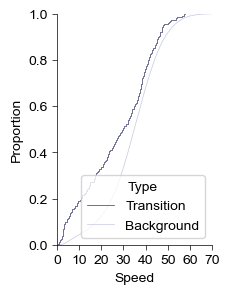

KS Test Map 0: KstestResult(statistic=0.21172638436482086, pvalue=1.943786191466234e-06, statistic_location=25.867011116054087, statistic_sign=1)


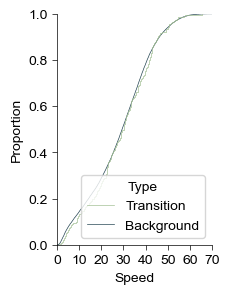

KS Test Map 1: KstestResult(statistic=0.0787037037037037, pvalue=0.5162856142686267, statistic_location=16.648404394715968, statistic_sign=-1)



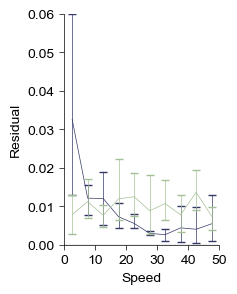

Map 0: F_onewayResult(statistic=3.2972586742985333, pvalue=0.006576634648812603)
Map 1: F_onewayResult(statistic=0.4878481438337776, pvalue=0.8710845144722836)


In [20]:
import scipy.stats

DM = GetDMatrices(1, 48)

def identify_transition_pos(dist_piece: np.ndarray, low_b: float, hig_b: float):
    map_piece = np.where(dist_piece >= 0, 1, 0)
    for i in range(1, len(map_piece)):
        if map_piece[i-1] == 0 and map_piece[i] == 1:
            if dist_piece[i] < hig_b:
                map_piece[i] = 0
        elif map_piece[i-1] == 1 and map_piece[i] == 0:
            if dist_piece[i] > low_b:
                map_piece[i] = 1
    dmap = np.ediff1d(map_piece)
    idx = np.where(dmap != 0)[0]
    
    # State transition should maintain for over 500 ms (5 time bins)
    if len(idx) == 0:
        return idx, np.where(dmap[idx] == -1, 1, 0)
    
    delete_idx = []
    jump_idx = -1
    for i in range(0, len(idx)-1):
        if i == jump_idx:
            continue
        
        try:
            if idx[i+1] - idx[i] <= 5:
                delete_idx.append(i)
                delete_idx.append(i+1)
                jump_idx = i+1
        except:
            pass
    
    if len(delete_idx) > 0:
        idx = np.delete(idx, np.array(delete_idx))
    return idx, np.where(dmap[idx] == -1, 1, 0)

def transitions_speed(
    dist_clusters: np.ndarray,
    session_clusters: np.ndarray,
    speed_clusters: np.ndarray,
    beg: np.ndarray, end:np.ndarray
):
    
    speed, mapt, session = [], [], []
    low_b, hig_b = 0, 0
    for i in range(len(beg)):
        dmap, map_type = identify_transition_pos(
            dist_clusters[beg[i]:end[i]], low_b, hig_b
        )
        speed.append(speed_clusters[dmap+beg[i]])
        mapt.append(map_type)
        session.append(session_clusters[dmap+beg[i]])
            
    return np.concatenate(speed), np.concatenate(session), np.concatenate(mapt)

if exists(join(figdata, code_id+" [switch speed].pkl")) == False:
    SData = {
        "MiceID": [],
        "Session": [],
        "Speed": [],
        "Map": []
    }
    
    BGSData = {
        "MiceID": [],
        "Session": [],
        "Speed": [],
        "Map": []
    }
    
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        if exists(join(loc, f"{mouse}.pkl")):
            with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
                map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end = pickle.load(handle)
        else:
            traces = []
            for i in np.where(f2['MiceID'] == mouse)[0]:
                with open(f2['Trace File'][i], 'rb') as handle:
                    trace = pickle.load(handle)
                traces.append(trace)

            with open(f_CellReg_dsp['cellreg_folder'][1+m], 'rb') as handle:
                index_map = pickle.load(handle)
            
                if mouse != 10232:
                    index_map = index_map[1:, :]
            
            map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end = counts(traces, index_map.astype(np.int64))
            with open(join(loc, f"{mouse}.pkl"), 'wb') as f:
                pickle.dump(
                    [map_clusters, session_traj, dist_clusters, dists, route_traj, lap_traj, pos_traj, speed_traj, beg, end],
                    f
                )
            
        sp, s, mp = transitions_speed(dist_clusters, session_traj, speed_traj, beg, end)
        
        SData['MiceID'].append(np.repeat(mouse, s.shape[0]))
        SData['Speed'].append(sp)
        SData['Session'].append(s)
        SData['Map'].append(mp)
        
        BGSData['MiceID'].append(np.repeat(mouse, speed_traj.shape[0]))
        BGSData['Speed'].append(speed_traj)
        BGSData['Session'].append(session_traj)
        BGSData['Map'] += [np.where(dist_clusters >= 0, 1, 0)]
        
    for k in SData.keys():
        SData[k] = np.concatenate(SData[k])
        BGSData[k] = np.concatenate(BGSData[k])
        
    with open(join(figdata, code_id+' [switch speed].pkl'), 'wb') as handle:
        pickle.dump((SData, BGSData), handle)
    
    D = pd.DataFrame(SData)
    D.to_excel(join(figdata, code_id+' [switch speed].xlsx'), index=False)
    SHData = {
        "Speed": [],
        "Residual": [],
        "MiceID": [],
        "Map": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        x0 = np.histogram(
            SData['Speed'][(SData['MiceID'] == mouse)&(SData['Map'] == 0)],
            range=(0, 50), bins=10
        )[0]
        x1 = np.histogram(
            SData['Speed'][(SData['MiceID'] == mouse)&(SData['Map'] == 1)],
            range=(0, 50), bins=10
        )[0]
        
        y0 = np.histogram(
            BGSData['Speed'][(BGSData['MiceID'] == mouse)&(BGSData['Map'] == 0)],
            range=(0, 50), bins=10
        )[0]
        y1 = np.histogram(
            BGSData['Speed'][(BGSData['MiceID'] == mouse)&(BGSData['Map'] == 1)],
            range=(0, 50), bins=10
        )[0]
        
        SHData['MiceID'].append(np.repeat(mouse, 10))
        SHData['Residual'].append(x0/y0)
        SHData['Map'].append(np.repeat(0, 10))
        SHData['Speed'].append(np.linspace(2.5, 47.5, 10))
        
        SHData['MiceID'].append(np.repeat(mouse, 10))
        SHData['Residual'].append(x1/y1)
        SHData['Map'].append(np.repeat(1, 10))
        SHData['Speed'].append(np.linspace(2.5, 47.5, 10))
        
    for k in SHData.keys():
        SHData[k] = np.concatenate(SHData[k])
        
    with open(join(figdata, code_id+' [switch speed hist].pkl'), 'wb') as f:
        pickle.dump(SHData, f)    
        
else:
    with open(join(figdata, code_id+' [switch speed].pkl'), 'rb') as handle:
        SData, BGSData = pickle.load(handle)

    with open(join(figdata, code_id+' [switch speed hist].pkl'), 'rb') as handle:
        SHData = pickle.load(handle)

  
print(SData['Speed'].shape, BGSData['Speed'].shape)
SData['Speed'] = SData['Speed']

WholeData = {}
for k in SData.keys():
    WholeData[k] = np.concatenate([SData[k], BGSData[k]])
    
WholeData['Type'] = np.concatenate([np.repeat("Transition", SData['Speed'].shape[0]), np.repeat("Background", BGSData['Speed'].shape[0])])

fig = plt.figure(figsize=(2, 3))
colors = [sns.color_palette("Purples", 2)[0], sns.color_palette("Purples", 2)[0]]
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData0 = SubDict(WholeData, WholeData.keys(), np.where(WholeData['Map'] == 0)[0])
sns.ecdfplot(
    data=SubData0,
    x='Speed',
    hue="Type",
    ax=ax,
    palette=['#333766', colors[0]],
    linewidth=0.5
)

ax.set_xlim(0, 70)
ax.set_xticks(np.linspace(0, 70, 8))
plt.savefig(join(loc, "Transition Speed [Map 0].png"), dpi=600)
plt.savefig(join(loc, "Transition Speed [Map 0].svg"), dpi=600)
plt.show()
transition_idx0 = np.where(SubData0['Type'] == 'Transition')[0]
background_idx0 = np.random.choice(
    np.where(SubData0['Type'] == 'Background')[0],
    size=transition_idx0.shape[0]
)
print(f"KS Test Map 0: {ks_2samp(SubData0['Speed'][transition_idx0], SubData0['Speed'][background_idx0])}")

fig = plt.figure(figsize=(2, 3))
colors = [sns.color_palette("Purples", 2)[0], sns.color_palette("Purples", 2)[0]]
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData1 = SubDict(WholeData, WholeData.keys(), np.where(WholeData['Map'] == 1)[0])
sns.ecdfplot(
    data=SubData1,
    x='Speed',
    hue="Type",
    palette=['#A4C096', '#264653'],
    ax=ax,
    linewidth=0.5
)
ax.set_xlim(0, 70)
ax.set_xticks(np.linspace(0, 70, 8))
plt.savefig(join(loc, "Transition Speed [Map 1].png"), dpi=600)
plt.savefig(join(loc, "Transition Speed [Map 1].svg"), dpi=600)
plt.show()
transition_idx1 = np.where(SubData1['Type'] == 'Transition')[0]
background_idx1 = np.random.choice(
    np.where(SubData1['Type'] == 'Background')[0],
    size=transition_idx1.shape[0]
)
print(f"KS Test Map 1: {ks_2samp(SubData1['Speed'][transition_idx1], SubData1['Speed'][background_idx1])}", end='\n\n')

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Speed',
    y='Residual',
    data=SHData,
    hue='Map',
    linewidth=0.5,
    err_kws={'linewidth':0.5, 'capsize': 3},
    palette=['#333766', '#A4C096'],
    err_style='bars',
    legend=False
)
ax.axhline(0, ls=':', color='k', linewidth=0.25)
ax.set_xlim(0, 50)
ax.set_xticks(np.linspace(0, 50, 6))
ax.set_ylim(0, 0.06)
plt.savefig(join(loc, "Transition Speed Residual.png"), dpi=600)
plt.savefig(join(loc, "Transition Speed Residual.svg"), dpi=600)
plt.show()

print(f"Map 0: {f_oneway(*[SHData['Residual'][np.where((SHData['Speed'] == x)&(SHData['Map'] == 0)&(np.isnan(SHData['Residual']) == False))[0]] for x in np.linspace(2.5, 47.5, 10)])}")
print(f"Map 1: {f_oneway(*[SHData['Residual'][np.where((SHData['Speed'] == x)&(SHData['Map'] == 1)&(np.isnan(SHData['Residual']) == False))[0]] for x in np.linspace(2.5, 47.5, 10)])}")

# Example Laps

session 1, Map 0, Route 2, Lap 13 (20)


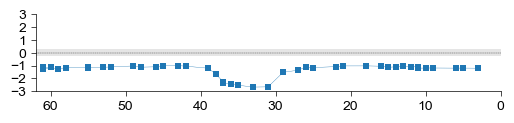

session 2, Map 1, Route 4, Lap 81 (40)


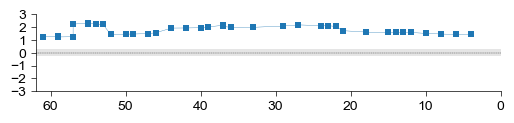

session 3, Map 1, Route 4, Lap 155 (31)


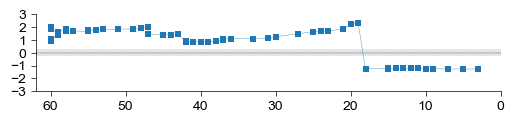

session 3, Map 0, Route 1, Lap 211 (95)


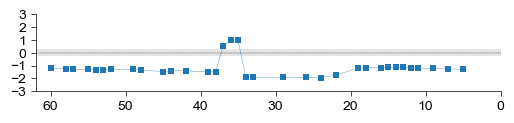

session 1, Map 0, Route 2, Lap 13 (20)


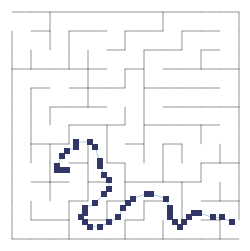

session 2, Map 1, Route 4, Lap 81 (40)


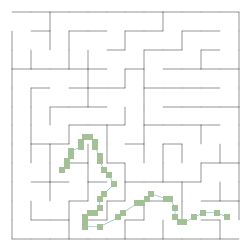

session 3, Map 1, Route 4, Lap 155 (31)


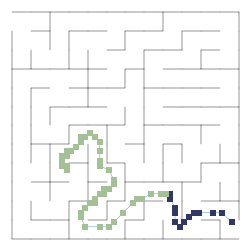

session 3, Map 0, Route 1, Lap 211 (95)


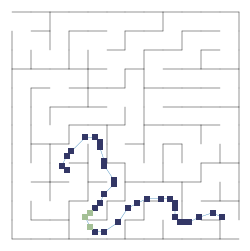

In [42]:
dist_colors = plt.get_cmap("rainbow")(dists/np.max(dists)*0.999)

i = 50
def plot_traj(i):
    plt.figure(figsize=(6,1))
    print(f"session {session_traj[beg[i]]+1}, Map {map_clusters[beg[i]]}, Route {route_traj[beg[i]]+1}, Lap {i} ({lap_traj[beg[i]]+1})")
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.plot(dists[beg[i]:end[i]], dist_clusters[beg[i]:end[i]], marker='s', markeredgewidth=0, markersize=4, linewidth=0.25)
    ax.axhline(0, ls='--', c='k', linewidth=0.25)
    ax.fill_between([0, 62], np.min(dist_clusters)*0.1, np.max(dist_clusters)*0.1, color = 'gray', alpha=0.2, edgecolor=None)
    #ax.scatter(dists[beg[i]:end[i]], np.repeat(np.max(dist_clusters)+0.4, end[i]-beg[i]), c=dist_colors[beg[i]:end[i]], 
    #    s=3, linewidth = 0)
    ax.set_xlim(62, 0)
    ax.set_ylim(-3, 3)
    ax.set_yticks(np.linspace(-3, 3,7))
    plt.savefig(join(loc, f"Example Map Transition [session {session_traj[beg[i]]+1}-Route {route_traj[beg[i]]}-Lap {i}].png"), dpi=600)
    plt.savefig(join(loc, f"Example Map Transition [session {session_traj[beg[i]]+1}-Route {route_traj[beg[i]]}-Lap {i}].svg"), dpi=600)
    plt.show()

plot_traj(13)
plot_traj(81)
plot_traj(155)
plot_traj(211)

def plot_maze(i):
    plt.figure(figsize=(3, 3))
    print(f"session {session_traj[beg[i]]+1}, Map {map_clusters[beg[i]]}, Route {route_traj[beg[i]]+1}, Lap {i} ({lap_traj[beg[i]]+1})")
    ax = Clear_Axes(plt.axes())
    DrawMazeProfile(axes=ax, color='k', linewidth=0.3)
    x, y = pos_traj[beg[i]:end[i]]%48, pos_traj[beg[i]:end[i]]//48
    ax.plot(x, y, marker='s', markeredgewidth=0, markersize=4, linewidth=0.25)
    ax.plot(x[dist_clusters[beg[i]:end[i]] <= np.min(dist_clusters)*0.1], 
            y[dist_clusters[beg[i]:end[i]] <= np.min(dist_clusters)*0.1], 
            's', markeredgewidth=0, markersize=4, linewidth=0.25, color = '#333766') #['#333766', '#A4C096']
    ax.plot(x[dist_clusters[beg[i]:end[i]] >= np.max(dist_clusters)*0.1], 
            y[dist_clusters[beg[i]:end[i]] >= np.max(dist_clusters)*0.1], 
            's', markeredgewidth=0, markersize=4, linewidth=0.25, color = '#A4C096')
    ax.set_aspect("equal")
    ax.invert_yaxis()
    plt.savefig(join(loc, f"Example Map Transition [session {session_traj[beg[i]]+1}-Route {route_traj[beg[i]]}-Lap {i}] Maze.png"), dpi=600)
    plt.savefig(join(loc, f"Example Map Transition [session {session_traj[beg[i]]+1}-Route {route_traj[beg[i]]}-Lap {i}] Maze.svg"), dpi=600)
    plt.show()

plot_maze(13)
plot_maze(81)
plot_maze(155)
plot_maze(211)

# Schematic illustration

        E:\Data\FinalResults\Dsp\0838 - Neural Trajectory Remapping is already existed!
2501


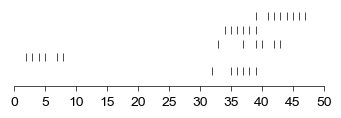

In [46]:
from mylib.statistic_test import *

code_id = "0838 - Neural Trajectory Remapping"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

with open(f2['Trace File'][34], 'rb') as handle:
    trace = pickle.load(handle)

beg = np.where((trace['ms_time'] >= trace['lap beg time'][34]))[0][0] + 54
end = beg+51

dt = trace['ms_time'][end-1] - trace['ms_time'][beg]
print(dt)

fig = plt.figure(figsize=(4, 1))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right', 'left'])

for k , i in enumerate([0, 2, 4, 8, 9]):
    x = np.where(trace['Spikes_original'][i, beg:end] == 1)[0]
    ax.plot(x, trace['Spikes_original'][i, beg:end][x]+k, '|', markeredgewidth=0.5, markersize = 6, color='k')
ax.set_xlim([0, 50])
ax.set_ylim(-0.1, 5.5)
ax.set_xticks(np.linspace(0, 50, 11))

plt.savefig(join(loc, "[Illustration] Spikes.png"), dpi=600)
plt.savefig(join(loc, "[Illustration] Spikes.svg"), dpi=600)
plt.show()